In [ ]:
#This Notebook will show training Squeezenet on Pytorch Summary of the notebook

#Training has THREE parts Optimization of Hyperparameters using Sequential Model Based Optimization (SMBO). 
#Fitting the Model with the best hyperparameters obtained from optimization. 
#Testing the Model on test set For optimization: Trained with 15 epochs and patient of 3. 
#Total of 300 trials for looking of best hyperparameters combination. 
#For fitting the Model with best hyperparameters: Trained with 100 epochs and patient of 10.

In [1]:
import os
import torch
import time
import random
import hyperopt
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from hyperopt.pyll.stochastic import sample
from torch.utils.data import DataLoader
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from torch.optim import Adam, SGD, RMSprop
from torchvision.models import mobilenet_v2
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#Checking Training machine
!nvidia-smi

Sat Feb  3 15:04:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        On  | 00000000:07:00.0 Off |                  N/A |
| 37%   48C    P8              16W / 170W |   2811MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
def get_data_loader(batch_size):
    train_transform = transforms.Compose([  #Train set Transform
        transforms.Resize((128, 128)),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([ #Validation set Transform
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

    #Transform train and validation set
    train_dataset = ImageFolder(root='/home/g6501222802/thesis/opt_data/train', transform=train_transform)
    val_dataset = ImageFolder(root='/home/g6501222802/thesis/opt_data/val', transform=val_transform)

    #Creating Loader
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

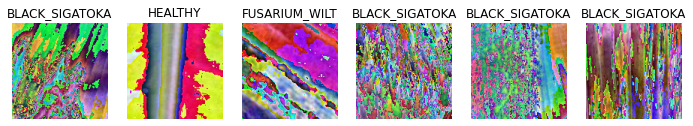

In [6]:
# Print some random images from the dataset
train_transform = transforms.Compose([    # Define data transformations including data augmentation
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_dataset = datasets.ImageFolder('/home/g6501222802/thesis/opt_data/train', transform=train_transform)
sample_indices = random.sample(range(len(train_dataset)), 6)
sample_images, sample_labels = zip(*[train_dataset[i] for i in sample_indices])
sample_images = [transforms.functional.to_pil_image(img) for img in sample_images]
sample_labels = [train_dataset.classes[label] for label in sample_labels]

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(np.array(sample_images[i]))
    plt.title(sample_labels[i])
    plt.axis('off')
plt.show()

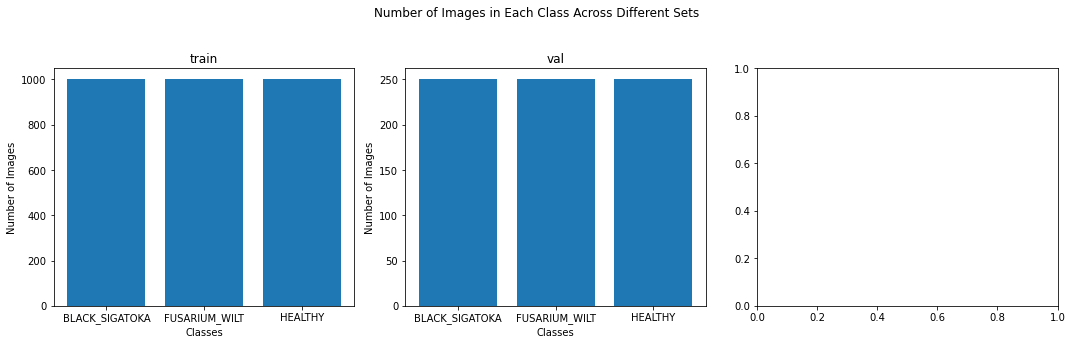

In [7]:
def count_images_in_directory(directory):
    return len([file for file in os.listdir(directory) if file.endswith('.jpg')])

# Main directory path
main_directory_path = '/home/g6501222802/thesis/opt_data'

# Sub-directories
sets = ['train', 'val']
classes = ['BLACK_SIGATOKA', 'FUSARIUM_WILT', 'HEALTHY']

# Dictionary to hold image counts
image_counts = {set_name: {class_name: 0 for class_name in classes} for set_name in sets}

# Counting images in each set and class
for set_name in sets:
    for class_name in classes:
        dir_path = os.path.join(main_directory_path, set_name, class_name)
        image_counts[set_name][class_name] = count_images_in_directory(dir_path)

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Number of Images in Each Class Across Different Sets')

for i, set_name in enumerate(sets):
    counts = [image_counts[set_name][class_name] for class_name in classes]
    axs[i].bar(classes, counts)
    axs[i].set_title(set_name)
    axs[i].set_xlabel('Classes')
    axs[i].set_ylabel('Number of Images')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
# Define call back for early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
def reset_globals():

    global train_losses, train_accuracies, val_losses, val_accuracies
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
# Call reset_globals before starting the optimization process
reset_globals()

def objective(params, iter_counter):

    global train_losses, train_accuracies, val_losses, val_accuracies
    
    early_stopping = EarlyStopping(patience=5, verbose=True)  #Early stopping

    start_time = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_loader, val_loader = get_data_loader(params['batch_size'])
    
    
    # Load the pretrained ShuffleNetV2 model
    model = models.shufflenet_v2_x1_0(pretrained=True)

    # Modify the classifier to fit 3 classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 3)
    model = model.to(device)     # Move the model to the device (CPU or GPU)


    criterion = nn.CrossEntropyLoss()

    # Optimizer selection
    if params['optimizer'] == 'Adam':
        optimizer = Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'SGD':
        optimizer = SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])
    else:  # RMSprop
        optimizer = RMSprop(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])

    epoch_data = []


    for epoch in range(15):

        model.train()
        train_loss =0.0
        train_correct= 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * train_correct / total
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_accuracy)


        # Validation loop
        model.eval()
        val_loss =0.0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()


        val_accuracy = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Acc: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}')
        epoch_data.append([epoch+1, train_accuracy, train_loss, val_accuracy, val_loss])
        
        
        # Check for early stopping
        early_stopping(val_losses[-1], model)
        if early_stopping.early_stop:
          print("Early stopping")
          break

    end_time = time.time()
    iteration_duration = end_time - start_time

    return {
        'loss': val_loss,
        'status': STATUS_OK,
        'val_accuracy': val_accuracy,
        'train_accuracy': train_accuracy,
        'train_loss': train_loss,
        'iteration_time': iteration_duration,
        'iter_counter': iter_counter,
        'params': params
    }

optimizer_choices = {Adam: 'Adam', SGD: 'SGD', RMSprop: 'RMSprop'}

space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
    'momentum': hp.uniform('momentum', 0.9, 0.99),
    'batch_size': hp.choice('batch_size', [32,64, 128, 256]),
    'optimizer': hp.choice('optimizer', [Adam, SGD, RMSprop]),
}

#Run Optimization with 300 trials
trials = Trials()
best = fmin(fn=lambda params: objective(params, len(trials.trials)), space=space, algo=tpe.suggest, max_evals=300, trials=trials)

# Extracting trial data and saving to CSV
results = []
for trial in trials.trials:
    result = trial['result']
    result['params']['optimizer'] = optimizer_choices[result['params']['optimizer']]
    results.append(result)

df = pd.DataFrame(results)
df.to_csv('/home/g6501222802/thesis/results/shufflenetv2_s1_results.csv', index=False)
print("Best parameters found:", best)


  0%|                                                                 | 0/300 [00:00<?, ?trial/s, best loss=?]

/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(

/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1: Train Acc: 47.20%, Train Loss: 179.1138, Val Acc: 33.33%, Val Loss: 25462088146944.0000              
Validation loss decreased (inf --> 2121840678912.000000). Saving model...                                     
Epoch 2: Train Acc: 54.67%, Train Loss: 400.0721, Val Acc: 50.67%, Val Loss: 95511567242793.3281              
EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 55.67%, Train Loss: 461.4851, Val Acc: 58.80%, Val Loss: 285438524580919.0625             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 4: Train Acc: 62.67%, Train Loss: 166.2841, Val Acc: 67.60%, Val Loss: 20.8509                          
Validation loss decreased (2121840678912.000000 --> 1.737577). Saving model...                                
Epoch 5: Train Acc: 66.13%, Train Loss: 68.6474, Val Acc: 66.93%, Val Loss: 126461.0710                       
E

Validation loss decreased (30.704286 --> 12.243303). Saving model...                                          
Epoch 9: Train Acc: 82.17%, Train Loss: 741.0591, Val Acc: 46.53%, Val Loss: 683.9289                         
EarlyStopping counter: 2 out of 5                                                                             
Epoch 10: Train Acc: 81.30%, Train Loss: 358.4345, Val Acc: 72.53%, Val Loss: 158.3503                        
EarlyStopping counter: 3 out of 5                                                                             
Epoch 11: Train Acc: 82.37%, Train Loss: 206.8752, Val Acc: 74.27%, Val Loss: 73.1117                         
Validation loss decreased (12.243303 --> 12.185284). Saving model...                                          
Epoch 12: Train Acc: 75.83%, Train Loss: 640.4360, Val Acc: 86.40%, Val Loss: 72171565.6580                   
EarlyStopping counter: 1 out of 5                                                                             
E

EarlyStopping counter: 3 out of 5                                                                             
Epoch 13: Train Acc: 99.80%, Train Loss: 0.1595, Val Acc: 97.47%, Val Loss: 0.5280                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 14: Train Acc: 99.83%, Train Loss: 0.1283, Val Acc: 98.13%, Val Loss: 0.4500                            
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 52.70%, Train Loss: 12177.7558, Val Acc: 49.73%, Val Loss: nan                            
Validation loss decreased (inf --> nan). Saving model...                                                      
Epoch 2: Train Acc: 65.63%, Train Loss: 7812.6097, Val Acc: 33.47%, Val Loss: nan                             
V

Validation loss decreased (247.070461 --> 1.121519). Saving model...                                          
Epoch 7: Train Acc: 86.80%, Train Loss: 37.4152, Val Acc: 80.00%, Val Loss: 3904.2662                         
EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 87.60%, Train Loss: 33.7981, Val Acc: 89.73%, Val Loss: 1178826.5608                      
EarlyStopping counter: 2 out of 5                                                                             
Epoch 9: Train Acc: 90.67%, Train Loss: 24.6201, Val Acc: 89.47%, Val Loss: 2998534.8507                      
EarlyStopping counter: 3 out of 5                                                                             
Epoch 10: Train Acc: 91.43%, Train Loss: 22.1219, Val Acc: 86.80%, Val Loss: 217006310.5829                   
EarlyStopping counter: 4 out of 5                                                                             
E

Epoch 1: Train Acc: 65.73%, Train Loss: 12.3356, Val Acc: 83.33%, Val Loss: 2.1906                            
Validation loss decreased (inf --> 0.730207). Saving model...                                                 
Epoch 2: Train Acc: 95.50%, Train Loss: 8.4320, Val Acc: 93.20%, Val Loss: 0.8148                             
Validation loss decreased (0.730207 --> 0.271605). Saving model...                                            
Epoch 3: Train Acc: 96.67%, Train Loss: 4.4692, Val Acc: 95.33%, Val Loss: 0.4939                             
Validation loss decreased (0.271605 --> 0.164637). Saving model...                                            
Epoch 4: Train Acc: 97.93%, Train Loss: 2.1526, Val Acc: 96.67%, Val Loss: 0.3345                             
Validation loss decreased (0.164637 --> 0.111501). Saving model...                                            
Epoch 5: Train Acc: 99.03%, Train Loss: 1.0615, Val Acc: 98.00%, Val Loss: 0.2383                             
V

Epoch 2: Train Acc: 97.70%, Train Loss: 1.9195, Val Acc: 94.80%, Val Loss: 0.7485                             
Validation loss decreased (0.451503 --> 0.249504). Saving model...                                            
Epoch 3: Train Acc: 98.33%, Train Loss: 0.6524, Val Acc: 96.67%, Val Loss: 0.4394                             
Validation loss decreased (0.249504 --> 0.146457). Saving model...                                            
Epoch 4: Train Acc: 98.90%, Train Loss: 0.4346, Val Acc: 97.47%, Val Loss: 0.2026                             
Validation loss decreased (0.146457 --> 0.067526). Saving model...                                            
Epoch 5: Train Acc: 99.67%, Train Loss: 0.1619, Val Acc: 97.33%, Val Loss: 0.2329                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 99.43%, Train Loss: 0.2109, Val Acc: 97.47%, Val Loss: 0.2790                             
E

Validation loss decreased (0.073669 --> 0.060309). Saving model...                                            
Epoch 6: Train Acc: 98.73%, Train Loss: 3.6431, Val Acc: 97.60%, Val Loss: 1.6101                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 98.70%, Train Loss: 3.7284, Val Acc: 97.47%, Val Loss: 1.3090                             
Validation loss decreased (0.060309 --> 0.054543). Saving model...                                            
Epoch 8: Train Acc: 98.63%, Train Loss: 3.6500, Val Acc: 98.27%, Val Loss: 1.5344                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 98.80%, Train Loss: 3.2218, Val Acc: 97.60%, Val Loss: 1.8357                             
EarlyStopping counter: 2 out of 5                                                                             
E

Epoch 9: Train Acc: 99.93%, Train Loss: 0.0432, Val Acc: 98.67%, Val Loss: 0.1705                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 10: Train Acc: 99.97%, Train Loss: 0.0393, Val Acc: 98.40%, Val Loss: 0.1922                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 11: Train Acc: 99.97%, Train Loss: 0.0219, Val Acc: 98.27%, Val Loss: 0.2039                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 12: Train Acc: 100.00%, Train Loss: 0.0154, Val Acc: 98.40%, Val Loss: 0.1947                           
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
E

EarlyStopping counter: 2 out of 5                                                                             
Epoch 13: Train Acc: 99.90%, Train Loss: 0.0581, Val Acc: 98.27%, Val Loss: 0.2217                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 14: Train Acc: 99.93%, Train Loss: 0.0467, Val Acc: 98.53%, Val Loss: 0.1907                            
EarlyStopping counter: 4 out of 5                                                                             
 14%|████▌                           | 43/300 [1:15:30<7:56:38, 111.28s/trial, best loss: 0.12310570292174816]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 3: Train Acc: 94.97%, Train Loss: 1.8297, Val Acc: 85.60%, Val Loss: 12.1489                            
Validation loss decreased (34.336035 --> 4.049632). Saving model...                                           
Epoch 4: Train Acc: 96.47%, Train Loss: 1.0090, Val Acc: 95.87%, Val Loss: 0.6812                             
Validation loss decreased (4.049632 --> 0.227061). Saving model...                                            
Epoch 5: Train Acc: 98.03%, Train Loss: 0.5935, Val Acc: 97.47%, Val Loss: 0.3145                             
Validation loss decreased (0.227061 --> 0.104848). Saving model...                                            
Epoch 6: Train Acc: 98.30%, Train Loss: 0.4662, Val Acc: 97.60%, Val Loss: 0.2308                             
Validation loss decreased (0.104848 --> 0.076921). Saving model...                                            
Epoch 7: Train Acc: 99.13%, Train Loss: 0.3105, Val Acc: 97.33%, Val Loss: 0.3486                             
E

Epoch 5: Train Acc: 98.97%, Train Loss: 3.4541, Val Acc: 98.53%, Val Loss: 0.7715                             
Validation loss decreased (0.046913 --> 0.032145). Saving model...                                            
Epoch 6: Train Acc: 99.17%, Train Loss: 2.9351, Val Acc: 98.27%, Val Loss: 0.8271                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 99.57%, Train Loss: 1.8375, Val Acc: 98.67%, Val Loss: 1.1081                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 8: Train Acc: 99.30%, Train Loss: 2.3425, Val Acc: 98.67%, Val Loss: 0.7371                             
Validation loss decreased (0.032145 --> 0.030711). Saving model...                                            
Epoch 9: Train Acc: 99.17%, Train Loss: 2.0788, Val Acc: 99.07%, Val Loss: 0.7445                             
E

Validation loss decreased (0.092017 --> 0.083461). Saving model...                                            
Epoch 8: Train Acc: 98.97%, Train Loss: 1.5856, Val Acc: 96.40%, Val Loss: 1.3855                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 98.87%, Train Loss: 1.3888, Val Acc: 97.07%, Val Loss: 1.1132                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 10: Train Acc: 98.37%, Train Loss: 2.0117, Val Acc: 97.47%, Val Loss: 0.8697                            
Validation loss decreased (0.083461 --> 0.072478). Saving model...                                            
Epoch 11: Train Acc: 98.90%, Train Loss: 1.4317, Val Acc: 97.47%, Val Loss: 1.1948                            
EarlyStopping counter: 1 out of 5                                                                             
E

Validation loss decreased (1.980450 --> 1.123359). Saving model...                                            
Epoch 6: Train Acc: 97.53%, Train Loss: 0.7964, Val Acc: 93.07%, Val Loss: 1.2735                             
Validation loss decreased (1.123359 --> 0.424515). Saving model...                                            
Epoch 7: Train Acc: 98.67%, Train Loss: 0.4747, Val Acc: 94.93%, Val Loss: 0.9171                             
Validation loss decreased (0.424515 --> 0.305688). Saving model...                                            
Epoch 8: Train Acc: 98.70%, Train Loss: 0.4443, Val Acc: 96.13%, Val Loss: 0.9357                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 99.10%, Train Loss: 0.3135, Val Acc: 96.67%, Val Loss: 0.5658                             
Validation loss decreased (0.305688 --> 0.188587). Saving model...                                            
E

Validation loss decreased (0.093008 --> 0.090211). Saving model...                                            
Epoch 7: Train Acc: 99.13%, Train Loss: 0.5946, Val Acc: 97.20%, Val Loss: 0.9151                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 98.20%, Train Loss: 1.1603, Val Acc: 97.07%, Val Loss: 0.9902                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 9: Train Acc: 98.57%, Train Loss: 1.1009, Val Acc: 96.13%, Val Loss: 0.7781                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 10: Train Acc: 98.50%, Train Loss: 1.0429, Val Acc: 96.40%, Val Loss: 0.8745                            
EarlyStopping counter: 4 out of 5                                                                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 4: Train Acc: 84.10%, Train Loss: 41.5914, Val Acc: 82.13%, Val Loss: 136726.5547                       
EarlyStopping counter: 2 out of 5                                                                             
Epoch 5: Train Acc: 82.67%, Train Loss: 51.7985, Val Acc: 86.00%, Val Loss: 9.9325                            
Validation loss decreased (2.617618 --> 0.413856). Saving model...                                            
Epoch 6: Train Acc: 84.20%, Train Loss: 39.0786, Val Acc: 84.40%, Val Loss: 32167648.2886                     
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 86.63%, Train Loss: 34.4942, Val Acc: 89.47%, Val Loss: 7.6467                            
Validation loss decreased (0.413856 --> 0.318613). Saving model...                                            
E

Epoch 5: Train Acc: 99.17%, Train Loss: 0.3448, Val Acc: 97.47%, Val Loss: 0.3210                             
Validation loss decreased (0.148737 --> 0.107005). Saving model...                                            
Epoch 6: Train Acc: 99.67%, Train Loss: 0.1515, Val Acc: 98.27%, Val Loss: 0.2170                             
Validation loss decreased (0.107005 --> 0.072334). Saving model...                                            
Epoch 7: Train Acc: 99.77%, Train Loss: 0.1229, Val Acc: 97.87%, Val Loss: 0.2322                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 99.83%, Train Loss: 0.0870, Val Acc: 97.73%, Val Loss: 0.2711                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 9: Train Acc: 99.83%, Train Loss: 0.0562, Val Acc: 98.27%, Val Loss: 0.2195                             
E

Validation loss decreased (0.074386 --> 0.062653). Saving model...                                            
Epoch 11: Train Acc: 100.00%, Train Loss: 0.2098, Val Acc: 98.53%, Val Loss: 0.1983                           
EarlyStopping counter: 1 out of 5                                                                             
Epoch 12: Train Acc: 99.97%, Train Loss: 0.1703, Val Acc: 98.80%, Val Loss: 0.2043                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 13: Train Acc: 99.60%, Train Loss: 0.2848, Val Acc: 98.53%, Val Loss: 0.1990                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 14: Train Acc: 99.83%, Train Loss: 0.1694, Val Acc: 98.13%, Val Loss: 0.2239                            
EarlyStopping counter: 4 out of 5                                                                             
E

Epoch 9: Train Acc: 74.80%, Train Loss: 2742.3149, Val Acc: 70.93%, Val Loss: 1214.3744                       
Validation loss decreased (1420665777077383168.000000 --> 50.598934). Saving model...                         
Epoch 10: Train Acc: 76.13%, Train Loss: 3923.3815, Val Acc: 74.00%, Val Loss: 12015276831214796800.0000      
EarlyStopping counter: 1 out of 5                                                                             
Epoch 11: Train Acc: 77.50%, Train Loss: 3853.7300, Val Acc: 56.27%, Val Loss: 89392193289617585888821248.0000
EarlyStopping counter: 2 out of 5                                                                             
Epoch 12: Train Acc: 81.33%, Train Loss: 3182.4041, Val Acc: 74.80%, Val Loss: nan                            
Validation loss decreased (50.598934 --> nan). Saving model...                                                
Epoch 13: Train Acc: 81.30%, Train Loss: 1688.7512, Val Acc: 76.00%, Val Loss: nan                            
V

Epoch 10: Train Acc: 98.47%, Train Loss: 0.5354, Val Acc: 94.93%, Val Loss: 0.4237                            
Validation loss decreased (0.216559 --> 0.141233). Saving model...                                            
Epoch 11: Train Acc: 98.53%, Train Loss: 0.4844, Val Acc: 95.33%, Val Loss: 0.4359                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 12: Train Acc: 98.60%, Train Loss: 0.5285, Val Acc: 95.60%, Val Loss: 0.4018                            
Validation loss decreased (0.141233 --> 0.133925). Saving model...                                            
Epoch 13: Train Acc: 99.30%, Train Loss: 0.2619, Val Acc: 94.93%, Val Loss: 7.5545                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 99.17%, Train Loss: 0.2254, Val Acc: 97.07%, Val Loss: 0.2562                            
V

Validation loss decreased (0.521625 --> 0.316056). Saving model...                                            
Epoch 3: Train Acc: 97.27%, Train Loss: 2.8950, Val Acc: 97.20%, Val Loss: 0.3184                             
Validation loss decreased (0.316056 --> 0.106142). Saving model...                                            
Epoch 4: Train Acc: 98.53%, Train Loss: 1.0753, Val Acc: 96.53%, Val Loss: 0.4141                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 99.10%, Train Loss: 0.5531, Val Acc: 96.93%, Val Loss: 0.3674                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 6: Train Acc: 99.37%, Train Loss: 0.3297, Val Acc: 97.47%, Val Loss: 0.2722                             
Validation loss decreased (0.106142 --> 0.090718). Saving model...                                            
E

Validation loss decreased (inf --> 10865394843648000.000000). Saving model...                                 
Epoch 2: Train Acc: 62.53%, Train Loss: 1502.5595, Val Acc: 34.80%, Val Loss: 97320495611904.0000             
Validation loss decreased (10865394843648000.000000 --> 16220082601984.000000). Saving model...               
Epoch 3: Train Acc: 62.43%, Train Loss: 1389.5145, Val Acc: 60.67%, Val Loss: 682508214075395.0000            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 4: Train Acc: 73.23%, Train Loss: 787.4063, Val Acc: 64.53%, Val Loss: 8471971511329095680.0000         
EarlyStopping counter: 2 out of 5                                                                             
Epoch 5: Train Acc: 76.70%, Train Loss: 600.2398, Val Acc: 70.67%, Val Loss: 17699928636225748992.0000        
EarlyStopping counter: 3 out of 5                                                                             
E

Epoch 2: Train Acc: 90.83%, Train Loss: 23.3107, Val Acc: 92.53%, Val Loss: 38.6434                           
Validation loss decreased (29.852803 --> 1.610144). Saving model...                                           
Epoch 3: Train Acc: 91.00%, Train Loss: 21.3614, Val Acc: 91.60%, Val Loss: 6.1456                            
Validation loss decreased (1.610144 --> 0.256065). Saving model...                                            
Epoch 4: Train Acc: 91.33%, Train Loss: 21.2323, Val Acc: 89.20%, Val Loss: 775.7962                          
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 94.10%, Train Loss: 15.4103, Val Acc: 93.87%, Val Loss: 5.3648                            
Validation loss decreased (0.256065 --> 0.223534). Saving model...                                            
Epoch 6: Train Acc: 95.57%, Train Loss: 12.1209, Val Acc: 93.73%, Val Loss: 177.4722                          
E

Early stopping                                                                                                
Epoch 1: Train Acc: 91.03%, Train Loss: 20.2223, Val Acc: 95.47%, Val Loss: 2.3462                            
Validation loss decreased (inf --> 0.195514). Saving model...                                                 
Epoch 2: Train Acc: 96.57%, Train Loss: 4.6435, Val Acc: 97.47%, Val Loss: 0.8521                             
Validation loss decreased (0.195514 --> 0.071007). Saving model...                                            
Epoch 3: Train Acc: 98.23%, Train Loss: 2.6023, Val Acc: 97.60%, Val Loss: 0.8769                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 4: Train Acc: 99.07%, Train Loss: 1.5331, Val Acc: 97.73%, Val Loss: 0.5462                             
Validation loss decreased (0.071007 --> 0.045520). Saving model...                                            
E

Epoch 15: Train Acc: 99.90%, Train Loss: 0.1666, Val Acc: 98.27%, Val Loss: 0.2024                            
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 84.17%, Train Loss: 9.7298, Val Acc: 88.27%, Val Loss: 2.0288                             
Validation loss decreased (inf --> 0.676259). Saving model...                                                 
Epoch 2: Train Acc: 96.80%, Train Loss: 2.4565, Val Acc: 93.07%, Val Loss: 1.1434                             
Validation loss decreased (0.676259 --> 0.381118). Saving model...                                            
Epoch 3: Train Acc: 98.40%, Train Loss: 0.6785, Val Acc: 96.27%, Val Loss: 0.4717                             
Validation loss decreased (0.381118 --> 0.157220). Saving model...                                            
E

Epoch 7: Train Acc: 99.57%, Train Loss: 0.1667, Val Acc: 98.27%, Val Loss: 0.2291                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 99.83%, Train Loss: 0.0985, Val Acc: 98.13%, Val Loss: 0.1868                             
Validation loss decreased (0.074793 --> 0.062282). Saving model...                                            
Epoch 9: Train Acc: 99.80%, Train Loss: 0.1050, Val Acc: 97.87%, Val Loss: 0.2521                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 99.87%, Train Loss: 0.0790, Val Acc: 98.00%, Val Loss: 0.2319                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 11: Train Acc: 99.80%, Train Loss: 0.1007, Val Acc: 98.13%, Val Loss: 0.2078                            
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 99.83%, Train Loss: 0.1422, Val Acc: 98.13%, Val Loss: 0.2238                             
Validation loss decreased (0.086095 --> 0.074603). Saving model...                                            
Epoch 9: Train Acc: 99.87%, Train Loss: 0.1278, Val Acc: 97.87%, Val Loss: 0.2101                             
Validation loss decreased (0.074603 --> 0.070034). Saving model...                                            
Epoch 10: Train Acc: 99.77%, Train Loss: 0.1244, Val Acc: 97.87%, Val Loss: 0.2529                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 11: Train Acc: 99.90%, Train Loss: 0.0902, Val Acc: 97.60%, Val Loss: 0.2960                            
EarlyStopping counter: 2 out of 5                                                                             
E

Epoch 10: Train Acc: 99.17%, Train Loss: 2.4186, Val Acc: 98.13%, Val Loss: 1.8460                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 11: Train Acc: 99.33%, Train Loss: 2.2937, Val Acc: 98.00%, Val Loss: 1.2279                            
Validation loss decreased (0.054344 --> 0.051164). Saving model...                                            
Epoch 12: Train Acc: 99.40%, Train Loss: 1.6153, Val Acc: 98.00%, Val Loss: 2.5908                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 13: Train Acc: 99.07%, Train Loss: 2.7854, Val Acc: 98.00%, Val Loss: 1.1404                            
Validation loss decreased (0.051164 --> 0.047518). Saving model...                                            
Epoch 14: Train Acc: 99.30%, Train Loss: 2.0225, Val Acc: 98.40%, Val Loss: 1.2053                            
E

Validation loss decreased (0.041630 --> 0.038624). Saving model...                                            
Epoch 13: Train Acc: 99.97%, Train Loss: 0.0245, Val Acc: 99.20%, Val Loss: 0.1225                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 99.93%, Train Loss: 0.0306, Val Acc: 99.33%, Val Loss: 0.1342                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 15: Train Acc: 99.93%, Train Loss: 0.0366, Val Acc: 99.07%, Val Loss: 0.1195                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 1: Train Acc: 69.30%, Train Loss: 12.0171, Val Acc: 91.60%, Val Loss: 1.7792                            
Validation loss decreased (inf --> 0.593073). Saving model...                                                 
E

Validation loss decreased (0.762908 --> 0.230058). Saving model...                                            
Epoch 3: Train Acc: 97.97%, Train Loss: 0.9418, Val Acc: 94.00%, Val Loss: 1.9559                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 4: Train Acc: 97.57%, Train Loss: 0.9851, Val Acc: 96.53%, Val Loss: 1.0837                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 5: Train Acc: 98.30%, Train Loss: 0.6011, Val Acc: 96.67%, Val Loss: 1.0919                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 6: Train Acc: 98.73%, Train Loss: 0.4042, Val Acc: 96.13%, Val Loss: 0.8683                             
EarlyStopping counter: 4 out of 5                                                                             
E

Epoch 4: Train Acc: 92.67%, Train Loss: 18.1900, Val Acc: 89.87%, Val Loss: 6.2056                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 5: Train Acc: 94.70%, Train Loss: 14.1314, Val Acc: 95.33%, Val Loss: 2.9076                            
Validation loss decreased (0.198867 --> 0.121149). Saving model...                                            
Epoch 6: Train Acc: 94.10%, Train Loss: 16.4457, Val Acc: 88.40%, Val Loss: 327.7788                          
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 93.33%, Train Loss: 15.8666, Val Acc: 94.40%, Val Loss: 3.4265                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 8: Train Acc: 96.10%, Train Loss: 9.5927, Val Acc: 93.47%, Val Loss: 3.7963                             
E

Epoch 6: Train Acc: 99.43%, Train Loss: 0.2101, Val Acc: 97.47%, Val Loss: 0.2727                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 99.70%, Train Loss: 0.1252, Val Acc: 97.87%, Val Loss: 0.2350                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 8: Train Acc: 99.77%, Train Loss: 0.0850, Val Acc: 97.87%, Val Loss: 0.2396                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 9: Train Acc: 99.93%, Train Loss: 0.0471, Val Acc: 98.27%, Val Loss: 0.1702                             
Validation loss decreased (0.063541 --> 0.056743). Saving model...                                            
Epoch 10: Train Acc: 99.83%, Train Loss: 0.0734, Val Acc: 98.53%, Val Loss: 0.1178                            
V

Validation loss decreased (0.056377 --> 0.051902). Saving model...                                            
Epoch 8: Train Acc: 99.77%, Train Loss: 0.1682, Val Acc: 98.00%, Val Loss: 0.4642                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 99.80%, Train Loss: 0.1734, Val Acc: 98.53%, Val Loss: 0.3078                             
Validation loss decreased (0.051902 --> 0.051305). Saving model...                                            
Epoch 10: Train Acc: 99.70%, Train Loss: 0.1784, Val Acc: 98.40%, Val Loss: 0.3894                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 11: Train Acc: 99.90%, Train Loss: 0.1079, Val Acc: 98.40%, Val Loss: 0.3950                            
EarlyStopping counter: 2 out of 5                                                                             
E

Epoch 6: Train Acc: 97.93%, Train Loss: 0.6660, Val Acc: 93.87%, Val Loss: 0.8842                             
Validation loss decreased (1.014437 --> 0.294746). Saving model...                                            
Epoch 7: Train Acc: 98.53%, Train Loss: 0.4867, Val Acc: 95.87%, Val Loss: 0.5810                             
Validation loss decreased (0.294746 --> 0.193654). Saving model...                                            
Epoch 8: Train Acc: 98.53%, Train Loss: 0.4857, Val Acc: 96.40%, Val Loss: 0.4372                             
Validation loss decreased (0.193654 --> 0.145735). Saving model...                                            
Epoch 9: Train Acc: 98.47%, Train Loss: 0.5401, Val Acc: 95.20%, Val Loss: 0.5162                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 99.17%, Train Loss: 0.2962, Val Acc: 96.40%, Val Loss: 0.3602                            
V

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 2: Train Acc: 82.07%, Train Loss: 23.7523, Val Acc: 74.40%, Val Loss: 526.8338                          
Validation loss decreased (10655.894555 --> 43.902817). Saving model...                                       
Epoch 3: Train Acc: 89.33%, Train Loss: 14.1882, Val Acc: 86.80%, Val Loss: 24.6230                           
Validation loss decreased (43.902817 --> 2.051914). Saving model...                                           
Epoch 4: Train Acc: 90.43%, Train Loss: 11.5130, Val Acc: 87.60%, Val Loss: 3.5810                            
Validation loss decreased (2.051914 --> 0.298416). Saving model...                                            
Epoch 5: Train Acc: 90.93%, Train Loss: 11.6705, Val Acc: 86.80%, Val Loss: 6.8059                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 91.60%, Train Loss: 10.7932, Val Acc: 92.67%, Val Loss: 3.8255                            
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 99.17%, Train Loss: 0.4105, Val Acc: 97.33%, Val Loss: 0.2535                             
Validation loss decreased (0.108320 --> 0.084496). Saving model...                                            
Epoch 7: Train Acc: 99.70%, Train Loss: 0.1747, Val Acc: 98.53%, Val Loss: 0.1574                             
Validation loss decreased (0.084496 --> 0.052462). Saving model...                                            
Epoch 8: Train Acc: 99.47%, Train Loss: 0.2140, Val Acc: 97.60%, Val Loss: 0.1959                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 99.80%, Train Loss: 0.1126, Val Acc: 97.47%, Val Loss: 0.2657                             
EarlyStopping counter: 2 out of 5                                                                             
E

Validation loss decreased (0.198770 --> 0.128168). Saving model...                                            
Epoch 4: Train Acc: 98.57%, Train Loss: 1.7238, Val Acc: 96.93%, Val Loss: 0.3332                             
Validation loss decreased (0.128168 --> 0.111078). Saving model...                                            
Epoch 5: Train Acc: 99.03%, Train Loss: 1.0246, Val Acc: 97.20%, Val Loss: 0.3288                             
Validation loss decreased (0.111078 --> 0.109604). Saving model...                                            
Epoch 6: Train Acc: 99.57%, Train Loss: 0.6081, Val Acc: 97.60%, Val Loss: 0.2707                             
Validation loss decreased (0.109604 --> 0.090219). Saving model...                                            
Epoch 7: Train Acc: 99.80%, Train Loss: 0.4153, Val Acc: 97.60%, Val Loss: 0.2741                             
EarlyStopping counter: 1 out of 5                                                                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 99.60%, Train Loss: 0.1505, Val Acc: 98.40%, Val Loss: 0.2025                             
Validation loss decreased (0.074917 --> 0.067490). Saving model...                                            
Epoch 7: Train Acc: 99.80%, Train Loss: 0.0947, Val Acc: 99.07%, Val Loss: 0.1434                             
Validation loss decreased (0.067490 --> 0.047791). Saving model...                                            
Epoch 8: Train Acc: 99.87%, Train Loss: 0.0655, Val Acc: 98.27%, Val Loss: 0.1927                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 100.00%, Train Loss: 0.0237, Val Acc: 98.53%, Val Loss: 0.2069                           
EarlyStopping counter: 3 out of 5                                                                             
E

Epoch 8: Train Acc: 99.93%, Train Loss: 0.1153, Val Acc: 98.13%, Val Loss: 0.1927                             
Validation loss decreased (0.070207 --> 0.064224). Saving model...                                            
Epoch 9: Train Acc: 99.97%, Train Loss: 0.1072, Val Acc: 98.13%, Val Loss: 0.2151                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 99.93%, Train Loss: 0.0842, Val Acc: 98.27%, Val Loss: 0.1848                            
Validation loss decreased (0.064224 --> 0.061586). Saving model...                                            
Epoch 11: Train Acc: 100.00%, Train Loss: 0.0686, Val Acc: 98.67%, Val Loss: 0.2161                           
EarlyStopping counter: 1 out of 5                                                                             
Epoch 12: Train Acc: 99.97%, Train Loss: 0.0573, Val Acc: 98.27%, Val Loss: 0.2118                            
E

Epoch 8: Train Acc: 99.60%, Train Loss: 0.8168, Val Acc: 98.13%, Val Loss: 0.5469                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 9: Train Acc: 99.80%, Train Loss: 0.6617, Val Acc: 98.27%, Val Loss: 0.7313                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 10: Train Acc: 99.67%, Train Loss: 0.5854, Val Acc: 98.53%, Val Loss: 0.6448                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 11: Train Acc: 99.67%, Train Loss: 0.7094, Val Acc: 98.40%, Val Loss: 0.7024                            
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
E

Epoch 2: Train Acc: 96.97%, Train Loss: 4.1713, Val Acc: 96.27%, Val Loss: 0.3527                             
Validation loss decreased (0.339667 --> 0.117562). Saving model...                                            
Epoch 3: Train Acc: 98.63%, Train Loss: 1.2721, Val Acc: 97.87%, Val Loss: 0.2674                             
Validation loss decreased (0.117562 --> 0.089142). Saving model...                                            
Epoch 4: Train Acc: 99.27%, Train Loss: 0.5315, Val Acc: 97.73%, Val Loss: 0.2805                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 99.27%, Train Loss: 0.3866, Val Acc: 98.13%, Val Loss: 0.1609                             
Validation loss decreased (0.089142 --> 0.053648). Saving model...                                            
Epoch 6: Train Acc: 99.53%, Train Loss: 0.2635, Val Acc: 98.80%, Val Loss: 0.1259                             
V

Validation loss decreased (inf --> 0.697890). Saving model...                                                 
Epoch 2: Train Acc: 97.23%, Train Loss: 1.3860, Val Acc: 94.67%, Val Loss: 1.0869                             
Validation loss decreased (0.697890 --> 0.362308). Saving model...                                            
Epoch 3: Train Acc: 97.07%, Train Loss: 0.9753, Val Acc: 95.87%, Val Loss: 0.8762                             
Validation loss decreased (0.362308 --> 0.292068). Saving model...                                            
Epoch 4: Train Acc: 98.27%, Train Loss: 0.6687, Val Acc: 98.00%, Val Loss: 0.2214                             
Validation loss decreased (0.292068 --> 0.073802). Saving model...                                            
Epoch 5: Train Acc: 99.13%, Train Loss: 0.3189, Val Acc: 98.00%, Val Loss: 0.1798                             
Validation loss decreased (0.073802 --> 0.059940). Saving model...                                            
E

Epoch 13: Train Acc: 100.00%, Train Loss: 0.0714, Val Acc: 98.80%, Val Loss: 0.1368                           
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 100.00%, Train Loss: 0.0614, Val Acc: 98.53%, Val Loss: 0.1443                           
EarlyStopping counter: 2 out of 5                                                                             
Epoch 15: Train Acc: 100.00%, Train Loss: 0.0537, Val Acc: 98.40%, Val Loss: 0.1485                           
EarlyStopping counter: 3 out of 5                                                                             
Epoch 1: Train Acc: 85.73%, Train Loss: 8.3671, Val Acc: 91.73%, Val Loss: 1.4056                             
Validation loss decreased (inf --> 0.468524). Saving model...                                                 
Epoch 2: Train Acc: 96.97%, Train Loss: 1.3585, Val Acc: 93.33%, Val Loss: 1.3593                             
V

In [4]:
# Define data transformations including data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(244),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Define data paths
train_data_path = '/home/g6501222802/thesis/Data/train'
valid_data_path = '/home/g6501222802/thesis/Data/val/'
test_data_path = '/home/g6501222802/thesis/Data/test/'

In [12]:
# Create data loaders
train_dataset = ImageFolder(train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)

valid_dataset = ImageFolder(valid_data_path, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=2)

test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load the pretrained ShuffleNetV2 model
model = models.shufflenet_v2_x1_0(pretrained=True)

# Modify the classifier to fit 3 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

In [8]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.000043, momentum=0.90)

In [10]:
# Define call back for early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='/home/g6501222802/thesis/results/shufflenetv2_best_model_checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10, verbose=True)

In [19]:
best_valid_loss = float('inf') 

# Training loop with early stopping
import time
start_time = time.time()
num_epochs = 150 # Adjust the number of epochs as needed


train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy.append(100 * correct_train / total_train)
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
    valid_accuracy.append(100 * correct_valid / total_valid)
    valid_losses.append(valid_loss / len(valid_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracy[-1]:.2f}%, "
          f"Valid Loss: {valid_losses[-1]:.4f}, "
          f"Valid Acc: {valid_accuracy[-1]:.2f}%")
    
      # Save model if validation loss has decreased
    if valid_losses[-1] < best_valid_loss:
        best_valid_loss = valid_losses[-1]
        torch.save(model.state_dict(), '/home/g6501222802/thesis/results/shufflenetv2_best_model_checkpoint.pt')

    # Check for early stopping
    early_stopping(valid_losses[-1], model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model checkpoint
model.load_state_dict(torch.load('/home/g6501222802/thesis/results/shufflenetv2_best_model_checkpoint.pt'))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/150, Train Loss: 1.0574, Train Acc: 76.76%, Valid Loss: 1.0588, Valid Acc: 76.07%
Validation loss decreased (1.059266 --> 1.058798). Saving model...
Epoch 2/150, Train Loss: 1.0569, Train Acc: 76.63%, Valid Loss: 1.0581, Valid Acc: 76.95%
Validation loss decreased (1.058798 --> 1.058121). Saving model...
Epoch 3/150, Train Loss: 1.0565, Train Acc: 76.74%, Valid Loss: 1.0577, Valid Acc: 76.77%
Validation loss decreased (1.058121 --> 1.057696). Saving model...
Epoch 4/150, Train Loss: 1.0562, Train Acc: 76.93%, Valid Loss: 1.0576, Valid Acc: 76.77%
Validation loss decreased (1.057696 --> 1.057553). Saving model...
Epoch 5/150, Train Loss: 1.0556, Train Acc: 77.21%, Valid Loss: 1.0573, Valid Acc: 77.54%
Validation loss decreased (1.057553 --> 1.057336). Saving model...
Epoch 6/150, Train Loss: 1.0552, Train Acc: 77.37%, Valid Loss: 1.0564, Valid Acc: 77.48%
Validation loss decreased (1.057336 --> 1.056382). Saving model...
Epoch 7/150, Train Loss: 1.0547, Train Acc: 77.65%, Valid 

Epoch 54/150, Train Loss: 1.0321, Train Acc: 82.14%, Valid Loss: 1.0336, Valid Acc: 82.17%
Validation loss decreased (1.034551 --> 1.033553). Saving model...
Epoch 55/150, Train Loss: 1.0315, Train Acc: 82.19%, Valid Loss: 1.0335, Valid Acc: 82.17%
Validation loss decreased (1.033553 --> 1.033457). Saving model...
Epoch 56/150, Train Loss: 1.0311, Train Acc: 82.05%, Valid Loss: 1.0325, Valid Acc: 81.82%
Validation loss decreased (1.033457 --> 1.032544). Saving model...
Epoch 57/150, Train Loss: 1.0306, Train Acc: 82.26%, Valid Loss: 1.0319, Valid Acc: 81.88%
Validation loss decreased (1.032544 --> 1.031882). Saving model...
Epoch 58/150, Train Loss: 1.0301, Train Acc: 82.05%, Valid Loss: 1.0322, Valid Acc: 81.94%
EarlyStopping counter: 1 out of 10
Epoch 59/150, Train Loss: 1.0294, Train Acc: 82.11%, Valid Loss: 1.0311, Valid Acc: 81.94%
Validation loss decreased (1.031882 --> 1.031066). Saving model...
Epoch 60/150, Train Loss: 1.0289, Train Acc: 82.35%, Valid Loss: 1.0307, Valid Acc: 

Epoch 108/150, Train Loss: 0.9999, Train Acc: 84.26%, Valid Loss: 1.0024, Valid Acc: 84.05%
Validation loss decreased (1.002399 --> 1.002370). Saving model...
Epoch 109/150, Train Loss: 0.9992, Train Acc: 84.38%, Valid Loss: 1.0011, Valid Acc: 83.81%
Validation loss decreased (1.002370 --> 1.001120). Saving model...
Epoch 110/150, Train Loss: 0.9985, Train Acc: 84.35%, Valid Loss: 0.9997, Valid Acc: 83.64%
Validation loss decreased (1.001120 --> 0.999687). Saving model...
Epoch 111/150, Train Loss: 0.9978, Train Acc: 84.15%, Valid Loss: 0.9998, Valid Acc: 83.87%
EarlyStopping counter: 1 out of 10
Epoch 112/150, Train Loss: 0.9973, Train Acc: 84.40%, Valid Loss: 0.9991, Valid Acc: 83.93%
Validation loss decreased (0.999687 --> 0.999111). Saving model...
Epoch 113/150, Train Loss: 0.9966, Train Acc: 84.35%, Valid Loss: 0.9983, Valid Acc: 83.58%
Validation loss decreased (0.999111 --> 0.998286). Saving model...
Epoch 114/150, Train Loss: 0.9958, Train Acc: 84.71%, Valid Loss: 0.9980, Vali

In [21]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure both inputs and labels are on the same device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        test_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU for consistency
        test_labels.extend(labels.cpu().numpy())  # Move labels to CPU for consistency

test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.9776
Test Accuracy: 84.21%


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {accuracy:.7f}")

# Calculate precision, recall, and F1 scores
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Precision: {precision:.7f}")
print(f"Recall: {recall:.7f}")
print(f"F1 Score: {f1:.7f}")

Test Accuracy: 0.8421206
Precision: 0.8776255
Recall: 0.8421206
F1 Score: 0.8403098


In [24]:
# Print classification report
class_names = test_dataset.classes
classification_rep = classification_report(test_labels, test_preds, target_names=class_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
                precision    recall  f1-score   support

BLACK_SIGATOKA       0.70      0.99      0.82      1154
 FUSARIUM_WILT       0.96      0.64      0.77      1152
       HEALTHY       0.97      0.90      0.93      1127

      accuracy                           0.84      3433
     macro avg       0.88      0.84      0.84      3433
  weighted avg       0.88      0.84      0.84      3433



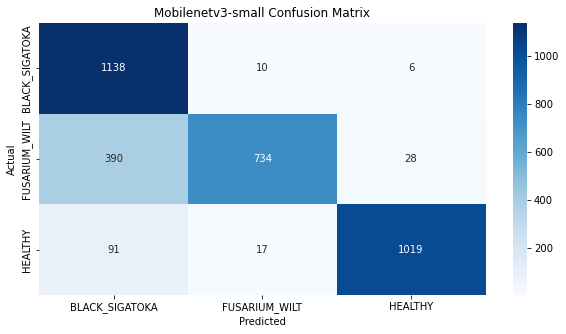

In [25]:
 # Calculate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Create a heatmap with seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Mobilenetv3-small Confusion Matrix')
plt.show()

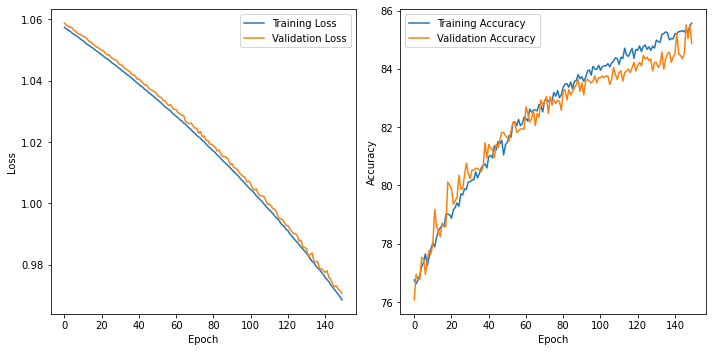

In [28]:
# Plot loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

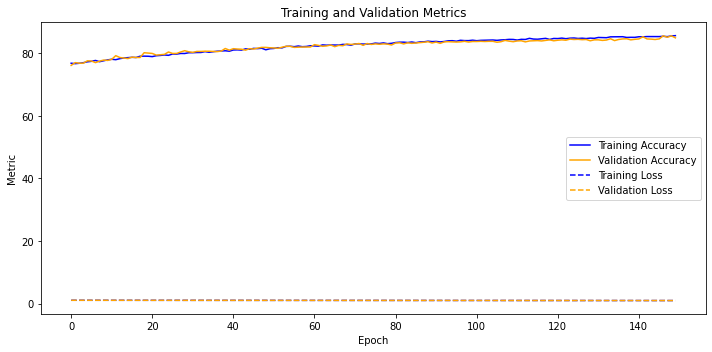

In [27]:
# Plot loss and accuracy graphs on a single set of axes
plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(valid_accuracy, label='Validation Accuracy', color='orange')

# Plot Loss
plt.plot(train_losses, label='Training Loss', linestyle='--', color='blue')
plt.plot(valid_losses, label='Validation Loss', linestyle='--', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Training and Validation Metrics')

plt.tight_layout()
plt.show()

In [ ]:
#Hyperparameters Optimization analysis

In [ ]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.9))}
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(1000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])

plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18);

In [ ]:
momentum = {'momentum': hp.uniform('momentum', 0.0, 0.9)}
momentum_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    momentum_dist.append(sample(momentum)['momentum'])

plt.figure(figsize = (8, 6))
sns.kdeplot(momentum_dist, color = 'blue', linewidth = 2, shade = True);
plt.title('Momentum Distribution', size = 18);
plt.xlabel('Momentum', size = 16); plt.ylabel('Density', size = 16);

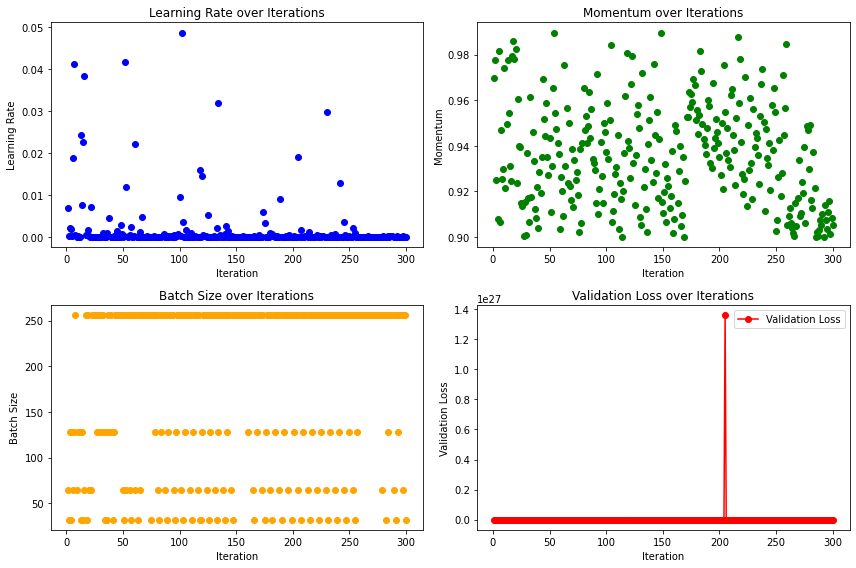

In [32]:
import ast
# Load the optimization results from the CSV file
results_df = pd.read_csv('/home/g6501222802/thesis/results/shufflenetv2_s1_results.csv')

# Convert the 'params' column from string to dictionary
results_df['params'] = results_df['params'].apply(ast.literal_eval)

iterations = np.array(results_df['iter_counter'])
loss = np.array(results_df['loss'])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Scatter plot for learning rate
axs[0, 0].scatter(iterations, results_df['params'].apply(lambda x: x['learning_rate']),  color='blue', marker='o', label='Learning Rate')

# Scatter plot for momentum
axs[0, 1].scatter(iterations, results_df['params'].apply(lambda x: x['momentum']),  color='green', marker='o', label='Momentum')

# Scatter plot for batch size
axs[1, 0].scatter(iterations, results_df['params'].apply(lambda x: x['batch_size']),  color='orange', marker='o', label='Batch Size')

# Line chart for objective values (e.g., validation loss) over iterations
axs[1, 1].plot(iterations, loss,  color='red', marker='o', label='Validation Loss')

# Set titles and labels for all subplots
axs[0, 0].set_title('Learning Rate over Iterations')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Learning Rate')

axs[0, 1].set_title('Momentum over Iterations')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Momentum')

axs[1, 0].set_title('Batch Size over Iterations')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Batch Size')

axs[1, 1].set_title('Validation Loss over Iterations')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Validation Loss')

# Display a combined legend for all subplots
plt.legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

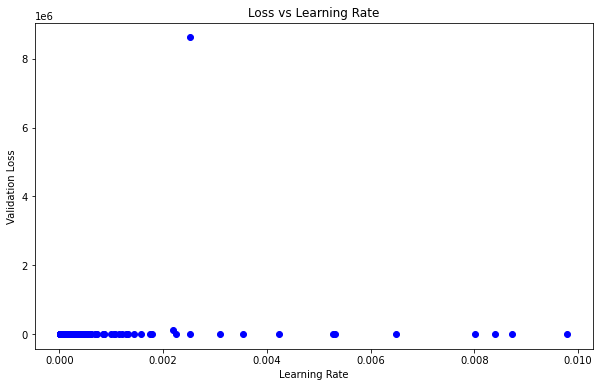

In [33]:
# Load the optimization results from the CSV file
results_df = pd.read_csv('/home/g6501222802/thesis/results/shufflev2-cbam_s2_results.csv')

# Convert the 'params' column from string to dictionary
results_df['params'] = results_df['params'].apply(ast.literal_eval)

fig, ax1 = plt.subplots(figsize=(10, 6))
# Create a scatter plot for loss against learning_rate
plt.scatter(results_df['params'].apply(lambda x: x['learning_rate']), results_df['loss'], color='blue', marker='o')
plt.title('Loss vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')

# Show the plot
plt.show()

In [36]:
#COunting the number of parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = models.shufflenet_v2_x1_0(pretrained=True)  # Pre-trained Mobilenetv2

total_params, trainable_params = count_parameters(model)
print(f'Total Parameters: {total_params}')
print(f'Trainable Parameters: {trainable_params}')

Total Parameters: 2278604
Trainable Parameters: 2278604


In [37]:
#Model Size Check
def model_size_in_memory(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    size_in_mb = param_size / (1024 ** 2)  # Convert to megabytes
    return size_in_mb

size_in_mb = model_size_in_memory(model)
print(f'Approximate Model Size in Memory: {size_in_mb:.2f} MB')

Approximate Model Size in Memory: 8.69 MB
